## Using Fourier Series to convert image to frequencies

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import write
from IPython.display import Audio
from matplotlib import animation, rc


In [2]:
#Load and convert image to grayscale
img = cv2.imread('drawing.png')
assert img is not None, "Image path not loaded correctly"
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #CV uses BGR instead of RGB

# convert the image to grayscale format
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#blur the image using Gaussian filter for noise reduction
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)

### Edge detection

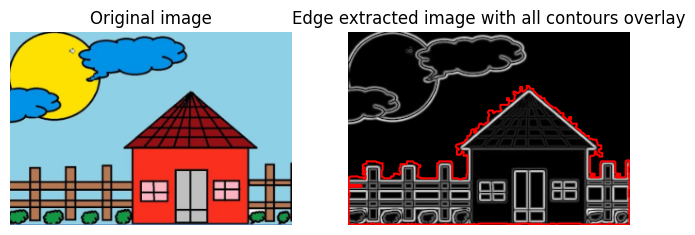

In [3]:
# Sobel Edge Detection
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)
sobelxy= np.sqrt(sobelx**2 + sobely**2)
sobelxy_abs = cv2.convertScaleAbs(sobelxy)

contours, _ = cv2.findContours(sobelxy_abs, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Find the largest contour by area
main_contour = max(contours, key=cv2.contourArea)

# Plot all contours without filtering, to inspect the results
fig, axs = plt.subplots(1, 2, figsize=(8,8))
axs[0].imshow(img)
axs[0].set_title("Original image")
axs[0].axis('off')

axs[1].imshow(sobelxy, cmap='gray')

# Extract (x, y) points from the main contour
contour_points = main_contour[:, 0, :]  # Extract (x, y) pairs
x_contour = contour_points[:, 0]
y_contour = contour_points[:, 1]
axs[1].plot(x_contour, y_contour, color='red')

axs[1].set_title("Edge extracted image with all contours overlay")
axs[1].axis('off')
plt.show()

### Calculating Fourier coefficients

In [4]:
def fourier_coefficients(x, y, n):
    #n- number of fourier coefficients
    L = 0 #total length

    #coefficients for x
    an = np.zeros(n)
    bn = np.zeros(n)

    #coefficients for y
    cn = np.zeros(n)
    dn = np.zeros(n)

    # Arrays for storage of edge length information
    dx = np.zeros(len(x))
    dy = np.zeros(len(x))
    dl = np.zeros(len(x))

    # Arrays for storage of sccumulated length information
    xj     = np.zeros(len(x))
    yj     = np.zeros(len(x))
    lj     = np.zeros(len(x))
    lj_prev= np.zeros(len(x))

    # Variables for maintaining cumulative length calculation
    sum_x = 0
    sum_y = 0
    sum_l = 0

    for i in range (0, len(x)):
        dx[i] = x[i] -  x[i-1]
        dy[i] = y[i] -  y[i-1]
        dl[i] = np.sqrt( dx[i]**2 + dy[i]**2 )

        xj[i]      = sum_x + dx[i]
        yj[i]      = sum_y + dy[i]
        lj[i]      = sum_l + dl[i]
        lj_prev[i] = sum_l

        sum_x = xj[i]
        sum_y = yj[i]
        sum_l = lj[i]

        L = L + dl[i]


    #calculating the summation for coefficient
    for i in range (0, n):
        n = i+1
        constant = L/(2*(np.pi**2.0)*(n**2.0))

        temp1 = dx/dl
        temp2 = dy/dl

        temp3 = (np.cos((2 *np.pi*n*lj)/L) - np.cos((2*np.pi*n*lj_prev)/L))
        temp4 = (np.sin((2 *np.pi*n*lj)/L) - np.sin((2*np.pi*n*lj_prev)/L))

        an[i] = constant*np.sum(temp1*temp3)
        bn[i] = constant*np.sum(temp1*temp4)

        cn[i] = constant*np.sum(temp2*temp3)
        dn[i] = constant*np.sum(temp2*temp4)
    
    return an, bn, cn, dn, L

In [5]:
n=100

#coefficients for x
an = np.zeros(n)
bn = np.zeros(n)

#coefficients for y
cn = np.zeros(n)
dn = np.zeros(n)

an, bn, cn, dn, L = fourier_coefficients(x_contour, y_contour, n)

### Inverse Fourier to approximate image

In [6]:
l = np.linspace(0, L, 1000)
approx_x = np.zeros(len(l))
approx_y = np.zeros(len(l))

for i in range(len(an)):

    x_cos = an[i]*np.cos((2*np.pi*(i+1)*l)/L)
    x_sin = bn[i]*np.sin((2*np.pi*(i+1)*l)/L)
    approx_x += (x_cos + x_sin)  

    y_cos = cn[i]*np.cos((2*np.pi*(i+1)*l)/L)
    y_sin = dn[i]*np.sin((2*np.pi*(i+1)*l)/L)
    approx_y += (y_cos + y_sin)

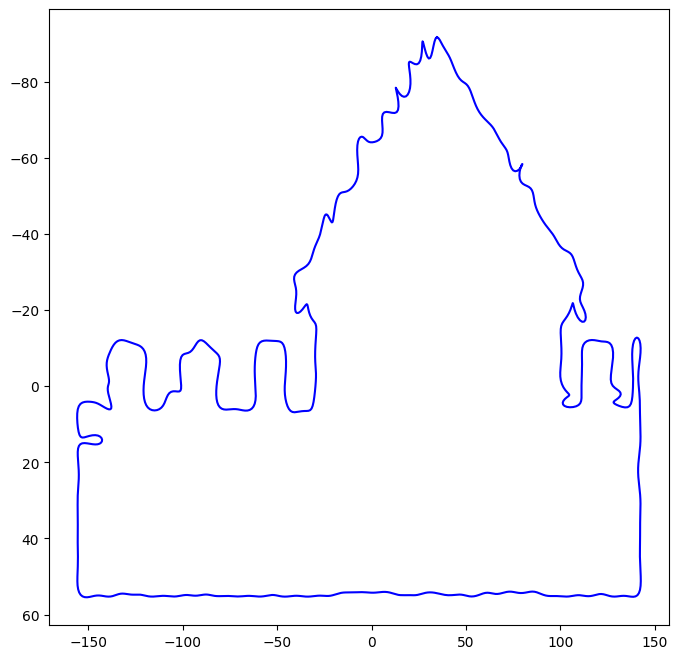

In [7]:
plt.figure(figsize=(8,8))
plt.gca().invert_yaxis() #In computer vision, origin is in top-left
plt.plot(approx_x, approx_y, 'b')
plt.show()

### Digital Direct Synthesis
N = increment amount = Fout/Fs * 2^(32)

Text(0.5, 1.0, 'Reconstructed Image using audio signals')

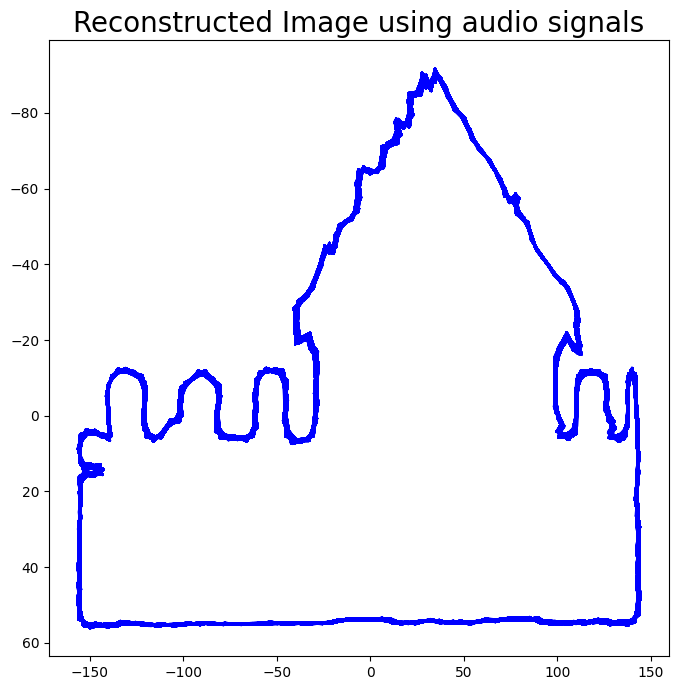

In [8]:
from matplotlib import animation, rc
import numpy as np
sampling_freq = 44000
phase = np.linspace(0, 2*np.pi, 256)
sin_LUT = np.sin(np.linspace(0, 2*np.pi, 256))
phase_increment = 262 * (2**32) / sampling_freq * np.arange(1, 101, 1)
phase_sin = np.zeros(100)
phase_cos = np.zeros(100) + (2**32 / 4.)

wave_x = np.zeros(88000)
wave_y = np.zeros(88000)
tone_x = []
tone_y = []
for i in range(88000):
    
    phase_sin += phase_increment
    phase_sin = phase_sin % (2**32 - 1)

    phase_cos += phase_increment
    phase_cos = phase_cos % (2**32 - 1)
    magnitude_sin = np.array([sin_LUT[int(j / (2**24))] for j in phase_sin]) # right shift 24 bit since using 8-bit sin table but 32-bit accumulator
    magnitude_cos = np.array([sin_LUT[int(j / (2**24))] for j in phase_cos])

    wave_x[i] = np.sum(bn * magnitude_sin + an * magnitude_cos)
    wave_y[i] = np.sum(dn * magnitude_sin + cn * magnitude_cos)
    tone_x.extend([np.sum(bn * magnitude_sin + an * magnitude_cos)])
    tone_y.extend([np.sum(dn * magnitude_sin + cn * magnitude_cos)])
fig1 = plt.figure(figsize=(8, 8))
plt.gca().invert_yaxis() 
plt.plot(tone_x, tone_y, 'b')
plt.title( "Reconstructed Image using audio signals", fontsize=20)


In [10]:
Audio(tone_y, rate=sampling_freq)

In [ ]:
from scipy.io.wavfile import write
import numpy as np
# Convert lists to numpy arrays
tone_x = np.array(tone_x)
tone_y = np.array(tone_y)


# Save the stereo audio
# tone_x = tone_x/max(abs(tone_x))
# tone_y = tone_y/max(abs(tone_y))
# plt.figure(figsize=(10, 6))
# plt.plot(tone_x[0:1000])

# plt.figure(figsize=(10, 6))
# plt.plot(tone_y[0:1000])

toney_stereo = (np.vstack((tone_y, tone_y))).transpose()
tonex_stereo = (np.vstack((tone_x, tone_x))).transpose()
# Produce an audio file that contains stereo sound

tonex_stereo[:, 0] = tonex_stereo[:, 0] / np.max(np.abs(tonex_stereo[:, 0]))  # Left channel
tonex_stereo[:, 1] = tonex_stereo[:, 1] / np.max(np.abs(tonex_stereo[:, 1]))  # Right channel

toney_stereo[:, 0] = toney_stereo[:, 0] / np.max(np.abs(toney_stereo[:, 0]))  # Left channel
toney_stereo[:, 1] = toney_stereo[:, 1] / np.max(np.abs(toney_stereo[:, 1]))  # Right channel

# plt.figure(figsize=(10, 6))
# plt.plot(tone_stereo[:1000, 0], label='Left Channel')
# plt.plot(tone_stereo[:1000, 1], label='Right Channel')
# plt.legend()
# plt.show()

write('stereox.wav', sampling_freq, tonex_stereo)
write('stereoy.wav', sampling_freq, toney_stereo)

# samplex_rate, data_x = wavfile.read('stereox.wav')
# sampley_rate, data_y = wavfile.read('stereoy.wav')

# left_channel = data_x[:,0]
# right_channel = data_y[:,0]
from pydub import AudioSegment
wav1 = AudioSegment.from_file("./stereox.wav", format="wav") 
wav2 = AudioSegment.from_file("./stereoy.wav", format="wav")
left = wav1.split_to_mono()[0]
right = wav2.split_to_mono()[0]
stereo_audio = AudioSegment.from_mono_audiosegments(left, right)
stereo_audio.export('test.wav', format="wav")